In [169]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [170]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [171]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)

model = cmip6_models[3]

In [172]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [173]:
# Load the DataArray containing the months of annual maximum temperature
annual_max_months_da_tx = xr.open_dataarray("txx_months_1981_2021.nc")
annual_max_months_da_tx.load()
annual_max_months_da_tw = xr.open_dataarray("tw_months_1981_2021.nc")
annual_max_months_da_tw.load()


<xarray.DataArray 'month' (year: 41, latitude: 721, longitude: 1440)>
array([[[ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7],
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]],

       [[ 8,  8,  8, ...,  8,  8,  8],
        [ 8,  8,  8, ...,  8,  8,  8],
        [ 7,  7,  7, ...,  7,  7,  7],
        ...,
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12]],

       [[ 8,  8,  8, ...,  8,  8,  8],
        [ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7],
        ...,
...
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]],

       [[ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7],
        ...,
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12]],

       [[ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7],
        ...,
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12]]])
Coordinates:
    time       (year, latitude, longitude) datetime64[ns] 1981-07-06 ... 2021...
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2018 2019 2020 2021

In [175]:
cmip6_tw = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tw/*.nc'%(dirCMIP6, model))
cmip6_tx = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tasmax/*day*.nc'%(dirCMIP6, model))



In [176]:
cmip6_tx = cmip6_tx.sel(time=slice('1981', '2020'))
cmip6_tw = cmip6_tw.sel(time=slice('1981', '2020'))

cmip6_tx = cmip6_tx.sel(lat=slice(-60,60))
cmip6_tw = cmip6_tw.sel(lat=slice(-60,60))

In [177]:
cmip6_tw.load()

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 192, time: 12240)
Coordinates:
    height   float64 2.0
  * time     (time) object 1981-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lat      (lat) float64 -59.38 -58.12 -56.88 -55.62 ... 56.88 58.12 59.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Data variables:
    tw       (time, lat, lon) float64 nan nan nan nan ... 5.461 6.202 6.291 nan

In [178]:
cmip6_tx.load()

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, time: 12240)
Coordinates:
  * time       (time) object 1981-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lat        (lat) float64 -59.38 -58.12 -56.88 -55.62 ... 56.88 58.12 59.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1981-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (lat, bnds) float64 -60.0 -58.75 -58.75 ... 58.75 58.75 60.0
    lon_bnds   (lon, bnds) float64 0.0 1.875 1.875 3.75 ... 358.1 358.1 360.0
    tasmax     (time, lat, lon) float32 274.4 274.4 274.3 ... 282.5 281.8 281.4
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  109500.0
    contact:                Hyun Min, Sung (sunghm122@korea.kr)
    creation_date:          2020-03-16T17:33:27Z
    data_specs_version:     01.00.30
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              day
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NIMS-KMA.KAC...
    grid:                   gs1x1
    grid_label:             gr
    history:                2020-03-16T17:33:27Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            National Institute of Meteorological Sciences/Kor...
    institution_id:         NIMS-KMA
    mip_era:                CMIP6
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       KACE-1-0-G
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    references:             Evaluation of the Korea Meteorological Administra...
    source:                 KACE1.0-G (2018): \naerosol: UKCA-GLOMAP-mode\nat...
    source_id:              KACE-1-0-G
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               day
    table_info:             Creation Date:(30 April 2019) MD5:cc2ae51c23960ce...
    title:                  KACE-1-0-G output prepared for CMIP6
    tracking_id:            hdl:21.14100/f844ae1f-1202-4c20-b86e-824fb03aa4d6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by NIMS-KMA is licensed...
    cmor_version:           3.4.0

In [179]:
cmip6_tx = cmip6_tx['tasmax']
cmip6_tx = cmip6_tx.reindex(lat=cmip6_tx.lat[::-1])

cmip6_tw = cmip6_tw['tw']
cmip6_tw = cmip6_tw.reindex(lat=cmip6_tw.lat[::-1])

In [180]:
annual_max_months_da_tx = annual_max_months_da_tx.rename({'latitude':'lat', 'longitude':'lon'})
regridder = xe.Regridder(annual_max_months_da_tx, cmip6_tx, 'bilinear', reuse_weights=False)
annual_max_months_da_tx_regrid = regridder(annual_max_months_da_tx)
annual_max_months_da_tw_regrid = regridder(annual_max_months_da_tw)

Create weight file: bilinear_721x1440_96x192.nc


In [181]:
# First create a boolean mask
mask = xr.full_like(cmip6_tx.time, False, dtype=bool)

# Iterate over the years
for y in annual_max_months_da_tx_regrid.year:
    # Find the month of max temperature in this year
    month_of_max_tx = annual_max_months_da_tx_regrid.sel(year=y)
    month_of_max_tw = annual_max_months_da_tw_regrid .sel(year=y)
    
    # Set True in the mask for all days of this month in this year
    mask = mask | (cmip6_tx.time.dt.month == month_of_max_tx) | (cmip6_tx.time.dt.month == month_of_max_tw)


# Apply the mask to select temperature data for the months of interest
cmip6_tx = cmip6_tx.where(mask, drop=True)
cmip6_tw = cmip6_tw.where(mask, drop=True)

In [182]:
correlation_per_year = []

# Iterate over the years
for y in range(1981, 2021 + 1):
    # Select data for this year
    cmip6_tx_year = cmip6_tx.sel(time=cmip6_tx.time.dt.year == y)
    cmip6_tw_year = cmip6_tw.sel(time=cmip6_tw.time.dt.year == y)

    print(y)
    # Calculate the correlation for this year and store it in the list
    correlation = xr.corr(cmip6_tx_year, cmip6_tw_year, dim='time')
    correlation['year'] = y  # Add a coordinate for the year
    correlation_per_year.append(correlation)

# Combine all the DataArrays along the 'year' dimension
correlation_per_year_da = xr.concat(correlation_per_year, dim='year')


1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [183]:
correlation_per_year_da.to_netcdf('tx_tw_corr_%s.nc'%model)

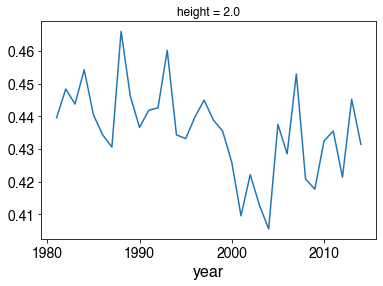

In [184]:
correlation_per_year_da.mean(dim=['lat', 'lon']).plot()

In [200]:
cur_tx_tw_corr

<xarray.Dataset>
Dimensions:                        (lat: 108, lon: 320, year: 41)
Coordinates:
  * lat                            (lat) float64 60.0 58.88 ... -58.88 -60.0
  * lon                            (lon) float64 0.0 1.125 2.25 ... 357.8 358.9
    height                         float64 2.0
  * year                           (year) int64 1981 1982 1983 ... 2020 2021
Data variables:
    __xarray_dataarray_variable__  (year, lat, lon) float64 nan nan ... nan nan

In [202]:
corr_ts = []
corr_ts_slopes = []
corr_ts_pvals = []


for model in cmip6_models:
    cur_tx_tw_corr = xr.open_dataset('tx_tw_corr_%s.nc'%model)
    cur_tx_tw_corr.load()
    cur_corr_ts = cur_tx_tw_corr.__xarray_dataarray_variable__.mean(dim=['lat', 'lon']).values
    corr_ts.append(cur_corr_ts)
    
    nn = np.where((~np.isnan(cur_corr_ts)))[0]
    X = sm.add_constant(cur_tx_tw_corr.year.values[nn])
    mdl = sm.OLS(cur_corr_ts[nn], X).fit()
    corr_ts_slopes.append(mdl.params[1])
    corr_ts_pvals.append(mdl.pvalues[1])
    
corr_ts = np.array(corr_ts)

In [203]:
corr_ts_slopes

[-0.000364295887711781,
 -0.000168502494149183,
 -0.0005345408853388895,
 -0.0006445892345668751,
 -0.0006121703009271486,
 -0.0002906953397533115,
 -0.0003090315915469945,
 -0.0006445143301139966]

In [204]:
corr_ts_pvals

[0.004296104647793216,
 0.2931884570088977,
 0.0006446906846573105,
 0.004841986812886987,
 0.049881935332540456,
 0.07180477873696943,
 0.07391301530449898,
 9.870727690374364e-05]

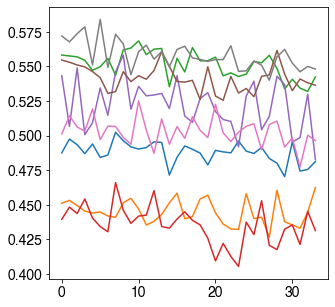

In [206]:


plt.figure(figsize=(5,5))
plt.plot(corr_ts.T)